In [237]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier

In [238]:
def read_csv(filename):
    data = []
    with open(filename) as file:
        reader = csv.reader(file)
        for row in reader:
            data.append(row)
    
    return data

In [239]:
train = read_csv("data/train.csv")
test = read_csv("data/test.csv")

cols = train[0]
rows = train[1:]

t_cols = test[0]
t_rows = test[1:]

train_df = pd.DataFrame(rows, columns=cols)
test_df = pd.DataFrame(t_rows, columns=t_cols)

In [240]:
def col_as_numeric(df_col, dtype):
    tmp = df_col.apply(lambda x: 0 if x == '' else dtype(x))
    mean_val = tmp[tmp != 0].mean()
    tmp[tmp == 0] = mean_val
    return tmp

def clean(df):
    col_keys = {}
    
    # Survived
    if 'Survived' in df.columns:
        df['Survived'] = df['Survived'].astype(int)
    
    # Age
    df['Age'] = col_as_numeric(df['Age'], float)
    
    # Age bins
    bin_cuts = [0, 11, 23, 34, 45, 57, 68, 100]
    df['Age_bin'] = pd.cut(df['Age'], bin_cuts).apply(lambda x: str(x))
    actual_bins = df['Age_bin'].unique()
    for age_bin in actual_bins[:-1]:
        if age_bin == np.nan:
            continue
        df[age_bin] = df['Age_bin'].apply(lambda x: 1 if x == age_bin else 0)
        
    # Age booleans
    # df['Young'] = df['Age'].apply(lambda x: 1 if x < 10 else 0)
    # df['MiddleAged'] = df['Age'].apply(lambda x: 1 if 21 <= x <= 50 else 0)
    # df['Old'] = df['Age'].apply(lambda x: 1 if x > 50 else 0)
    
    # Sex
    sex = pd.unique(df['Sex'].unique())
    sex = pd.DataFrame(sex, columns=['Sex'])
    sex['Sex_code'] = sex['Sex'].astype('category').cat.codes
    col_keys['Sex'] = sex
    df = pd.merge(left=df, right=sex, how='left', on='Sex')
    
    # SibSp - # of siblings / spouses aboard 
    df['SibSp'] = col_as_numeric(df['SibSp'], int)
    
    # Parch - # of parents / children aboard
    df['Parch'] = col_as_numeric(df['Parch'], int)
    
    # Total relatives
    df['Relatives'] = df['SibSp'] + df['Parch']
    
    # Fare
    df['Fare'] = col_as_numeric(df['Fare'], float)
    
    # Pclass
    df['Pclass'] = col_as_numeric(df['Pclass'], int)
    
    # Cabin - by letter class
    df['CabinClass'] = df['Cabin'].apply(lambda x: x if len(x) == 0 else x[0])
    
    temp_df = pd.DataFrame({'CabinClass': df['CabinClass'].unique(), 
                            'CabinClass_id':range(len(df['CabinClass'].unique()))})
    df = df.merge(temp_df, on='CabinClass', how='left')
    
    # Embarked
    temp_df = pd.DataFrame({'Embarked': df['Embarked'].unique(), 
                            'Embarked_id':range(len(df['Embarked'].unique()))})
    df = df.merge(temp_df, on='Embarked', how='left')
    return df

def map_ticket(x):
    comps = x.split(' ')
    if len(comps) == 1:
        return 'NUMBER'
    else:
        return comps[0].lower().replace('.', '')
# print(df['Ticket'].apply(map_ticket).unique())
df = clean(train_df)
t_df = clean(test_df)

[(11, 23], (34, 45], (23, 34], (45, 57], (0, 11], (57, 68], (68, 100]]
Categories (7, object): [(0, 11] < (11, 23] < (23, 34] < (34, 45] < (45, 57] < (57, 68] < (68, 100]]
[(34, 45], (45, 57], (57, 68], (23, 34], (11, 23], (0, 11], (68, 100]]
Categories (7, object): [(0, 11] < (11, 23] < (23, 34] < (34, 45] < (45, 57] < (57, 68] < (68, 100]]


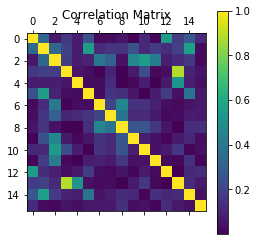

In [241]:
# Check correspondences to find any over 0.5 with survival 
corr = df.corr().abs()

plt.matshow(df.corr().abs())
cb = plt.colorbar()
plt.title('Correlation Matrix')
plt.show()

In [249]:
num_cols = df.select_dtypes('number').columns
df_numeric = df[num_cols]

df_numeric = df_numeric.dropna()
survived = df_numeric.pop('Survived')

X = df_numeric.to_numpy()
y = survived.to_numpy()

test_p = 0.8
t = int(test_p * len(y))
X_test = X[:t]
X_train = X[t:]
y_test = y[:t]
y_train = y[t:]

num_cols = t_df.select_dtypes('number').columns
print(t_df.columns)
t_df_numeric = t_df[num_cols]

t_df_numeric = t_df_numeric.dropna()

X_final = t_df_numeric.to_numpy()

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_bin', '(34, 45]',
       '(45, 57]', '(57, 68]', '(23, 34]', '(11, 23]', '(0, 11]', 'Sex_code',
       'Relatives', 'CabinClass', 'CabinClass_id', 'Embarked_id'],
      dtype='object')


In [243]:
clf = svm.SVC(gamma='scale', kernel='linear')
clf.fit(X_train, y_train)
print("SVM SVC:\n- train: {}\n- test: {}".format(clf.score(X_train, y_train), 
                                                 clf.score(X_test, y_test)))

SVM SVC:
- train: 0.8547486033519553
- test: 0.797752808988764


In [244]:
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=0)
ada_clf.fit(X_train, y_train)
print("AdaBoost, random forest:\n- train: {}\n- test: {}".format(ada_clf.score(X_train, y_train), 
                                                                 ada_clf.score(X_test, y_test)))

AdaBoost, random forest:
- train: 0.9608938547486033
- test: 0.7443820224719101


In [245]:
gr_clf = GradientBoostingClassifier(n_estimators=100, random_state=0)
gr_clf.fit(X_train, y_train)
print("Gradient Boosting, random forest:\n- train: {}\n- test: {}".format(gr_clf.score(X_train, y_train), 
                                                                          gr_clf.score(X_test, y_test)))

Gradient Boosting, random forest:
- train: 0.9888268156424581
- test: 0.7696629213483146


In [246]:
mlp_clf = clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                          hidden_layer_sizes=(75, 5, 2), random_state=0)
mlp_clf.fit(X_train, y_train)
print("Multilayer Perceptron:\n- train: {}\n- test: {}".format(mlp_clf.score(X_train, y_train), 
                                                               mlp_clf.score(X_test, y_test)))

Multilayer Perceptron:
- train: 0.8994413407821229
- test: 0.7823033707865169


In [247]:
eclf = VotingClassifier(estimators=[('svm', clf), 
                                    ('ada', ada_clf), 
                                    ('grb', gr_clf),
                                    ('mlp', mlp_clf)
                                    ], voting='hard')
eclf.fit(X_train, y_train)
print("Voting Classifier:\n- train: {}\n- test: {}".format(eclf.score(X_train, y_train), 
                                                           eclf.score(X_test, y_test)))

Voting Classifier:
- train: 0.9329608938547486
- test: 0.7823033707865169


In [252]:
y_final = eclf.predict(X_final)
df_final = pd.DataFrame({
    'PassengerId': t_df['PassengerId'],
    'Survived': y_final
})

df_final.to_csv("data/pred.csv", index=False)